<a href="https://colab.research.google.com/github/LFBenta/Film-outcomes-by-their-description/blob/main/%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D1%81%D0%B1%D0%BE%D1%80%D0%BE%D0%B2_%D1%84%D0%B8%D0%BB%D1%8C%D0%BC%D0%BE%D0%B2_%D0%BF%D0%BE_%D0%B8%D1%85_%D0%BE%D0%BF%D0%B8%D1%81%D0%B0%D0%BD%D0%B8%D1%8E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Оценка кассовых сборов фильма по описанию

### Библеотеки-Подключения

Представлены все подключения и библеотеки использованные в работе.

In [ ]:
# Mount to google drive for import and export data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Initial libraries
import pandas as pd
import re
import string
import numpy as np
import pickle
import tensorflow as tf

In [ ]:
# Regression models import from sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [ ]:
# Methods for getting metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
# Method for splitting sample to train and test
from sklearn.model_selection import train_test_split

In [ ]:
# Methods for dimensionality reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
# Methods for hyperparametrs search
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Spacy + trained pipeline import
import spacy
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Library witch got regression model
%pip install catboost
from catboost import CatBoostRegressor

## Предварительная обработка данных

### Загрузка датасета

In [ ]:
# Dataframe initializing
df = pd.read_csv("/content/drive/MyDrive/ВКР_External/movie_descriptions.csv")
df

,income,desc
0,6500000.0,...All the Marbles (reissued as The California...
1,935000.0,"20,000 Years in Sing Sing is a 1932 American P..."
2,5347122.0,ABBA: The Movie is a 1977 mocumentary about th...
3,325000000.0,"Disney's A Christmas Carol, or simply A Christ..."
4,3400000.0,A Funny Thing Happened on the Way to the Forum...
...,...,...
14502,511203.0,The Escape is a 2017 British drama film direct...
14503,709.0,Les Estivants (transl. The Summer House) is a ...
14504,12700000.0,"Atlantic City (French: Atlantic City, USA) is ..."
14505,18000000.0,Dead Men Don't Wear Plaid is a 1982 American n...


### Токенизация - Векторизация

In [ ]:
# Load pipeline as nlp
nlp = spacy.load("en_core_web_md")

In [ ]:
# Get stopwords
stopwords = nlp.Defaults.stop_words

In [ ]:
# Make doc object
def post_process(text):
  doc = nlp(text)
  tokens = [token.lower_ for token in doc if token.lower_ not in stopwords and token.lower_ not in string.punctuation]
  doc = nlp(' '.join(tokens))
  return doc

In [ ]:
# Apply doc to ea description in df
df["desc"] = df["desc"].apply(post_process)

In [ ]:
# Get vectors from doc to new df
l_data = []
df_append = pd.DataFrame(df["income"]).copy(deep=True)
for i in range(len(df.index)):
  l_data.append(df["desc"][i].vector)
df_vectorized = pd.DataFrame(l_data)
df_vectorized["income"] = df.income

### Сохранение датафрейма с векторами

In [ ]:
# Save df with vectors for future works
df_vectorized.to_csv("/content/drive/MyDrive/ВКР_External/movie_descriptions_vectorized.csv")

## Обучение моделей

### Определение параметров

In [ ]:
# Use df from previosly saved one
df_vectorized = pd.read_csv("/content/drive/MyDrive/ВКР_External/movie_descriptions_vectorized.csv")
df_vectorized

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,291,292,293,294,295,296,297,298,299,income
0,0,-1.298904,-0.242598,-0.857874,-1.144227,1.556783,-0.455883,1.524870,1.198163,-0.026661,...,-1.085548,0.336589,0.530162,-1.362267,-0.363953,1.943759,-0.764230,-1.157135,0.269557,6500000.0
1,1,-1.377147,-0.644655,-0.835660,-1.034678,1.139087,-0.930904,2.020840,2.214315,0.370975,...,0.012549,-0.474700,-0.034009,-1.644470,-0.349423,1.850026,-1.151727,-1.730281,0.514668,935000.0
2,2,-1.474902,0.256130,-0.032380,-2.101310,1.251606,-0.733639,1.310911,0.529010,-0.652214,...,-1.824025,-0.453622,1.056749,-1.000937,0.281683,1.457397,-0.048272,-2.931675,0.133844,5347122.0
3,3,-1.813950,-1.318756,-1.056335,-0.824261,1.489859,-1.098742,1.715052,1.391204,0.061601,...,-0.919328,0.270585,-0.014532,-1.217414,0.094761,1.942663,-0.749508,-1.774292,0.583732,325000000.0
4,4,-1.299850,-0.333140,-0.700350,-1.439572,1.237609,-0.140933,1.843368,1.420386,-0.599807,...,-1.329193,0.118996,0.065049,-1.205569,-0.639141,1.432785,-0.242925,-1.840069,0.795358,3400000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14502,14502,-1.119032,-0.777263,-1.233040,-1.777215,2.430745,-0.838345,3.168251,1.763835,0.348106,...,-1.450528,-0.389068,-0.085819,-1.456573,-0.346806,1.907644,-1.337442,-2.240242,0.385006,511203.0
14503,14503,-1.745673,-0.736937,-0.336830,-1.390641,1.382258,-0.731608,2.456317,1.139176,1.021985,...,-2.227930,1.305248,-0.309047,-1.259585,-0.059573,2.539666,-0.615935,-1.048922,0.306281,709.0
14504,14504,-1.639807,-1.232043,-1.241632,-0.908423,2.740597,-0.266506,1.996614,1.859926,0.396290,...,-0.890346,-0.131324,0.841622,-2.034261,-0.130795,1.601602,-1.005677,-1.472516,0.571674,12700000.0
14505,14505,-2.142270,-0.589301,-1.090148,-1.347771,0.955679,-0.869408,2.019832,2.197597,-0.266868,...,-1.126979,0.995757,0.005921,-1.744134,-0.063089,1.972861,0.180275,-1.270415,0.113823,18000000.0


In [ ]:
# Define params from df
y = df_vectorized["income"]
X = df_vectorized.drop(columns = ["income", "Unnamed: 0"])

In [ ]:
# Divide samples by train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Понижение размерности

Проверим, стоит ли использовать понижение размерности на наших данных

In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Baseline Model (without PCA)
baseline_model = LinearRegression()
baseline_model.fit(X_train_scaled, y_train)

# PCA Experiment
pca = PCA(n_components=0.95)
pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

pca_model = LinearRegression()
pca_model.fit(X_train_pca, y_train)


# Evaluation
print(f"Baseline MAE: {mean_absolute_error(y_test, baseline_model.predict(X_test_scaled))}")
print(f"PCA MAE: {mean_absolute_error(y_test, pca_model.predict(X_test_pca))}")
print(f"Baseline MSQ: {mean_squared_error(y_test, baseline_model.predict(X_test_scaled))}")
print(f"PCA MSQ: {mean_squared_error(y_test, pca_model.predict(X_test_pca))}")
print(f"Baseline r2_score: {r2_score(y_test, baseline_model.predict(X_test_scaled))}")
print(f"PCA r2_score: {r2_score(y_test, pca_model.predict(X_test_pca))}")

Baseline MAE: 131938991.96566764
PCA MAE: 118834587.4937029
Baseline MSQ: 1.0411709418017906e+17
PCA MSQ: 1.0083170115073768e+17
Baseline r2_score: 0.01195723439517482
PCA r2_score: 0.04313471625315424


Понижение размернности улучшило наши метрики на примерно 10%

In [ ]:
# Use pca split data instead of regular
X_train = X_train_pca
X_test = X_test_pca

На основе метрик, можно сделать вывод, что в понижении размерности большого смысла для текущих данных нет.

### Выбор гипер параметров для моделей

Список существующих(в работе) моделей и отдельно гиперпараметры, которые будут проверятся.

In [ ]:
# Define all models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'MLPRegressor': MLPRegressor(),
    'SVR': SVR(),
    'CatBoostRegressor': CatBoostRegressor()
}

In [ ]:
# Grid with vary amount of hyperparams
param_grid = {
    'LinearRegression': {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'n_jobs': [-1]
    },
    'Ridge': {
        'alpha': [0.01, 0.1, 1, 10],
        'max_iter': [100, 500, 1000, 2500, 5000],
        'tol': [1e-3, 1e-4, 1e-5]
    },
    'Lasso': {
        'alpha': [0.001, 0.01, 0.1, 1],
        'max_iter': [1000, 2500, 5000],
        'tol': [1e-5],
        'selection': ['random']
    },
    'MLPRegressor': {
        'activation': ['relu'],
        'max_iter': [200, 500, 1000]
    },
    'SVR': {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.5],
        'gamma': ['scale', 'auto'],
        'tol': [1e-3, 1e-4, 1e-5]
    },
    'CatBoostRegressor': {
        'iterations': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5, 7],
        'border_count': [32, 64, 128],
        'loss_function': ['RMSE', 'MAE'],
        'verbose': [False] # To suppress CatBoost's verbose output during tuning
    },
    'ElasticNet': {
        'alpha': [0.001, 0.01, 0.1, 1, 10],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
        'max_iter': [1000, 5000],
        'tol': [1e-4, 1e-5],
        'selection': ['cyclic', 'random']
    }
}

Есть несколько способов выбора гипер параметров, создадим на их основе функцию, для того чтобы вызывать их, когда будем проверять каждую модель по отдельности.

In [ ]:
# Grid search by model from the list
def do_grid_search(cur_model_name):
  for model_name, model in models.items():
    if cur_model_name in param_grid and model_name == cur_model_name:
        grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        best_params = grid_search.best_params_
        return best_params

In [ ]:
# Random search by model from the list
def do_random_search(cur_model_name):
  for model_name, model in models.items():
      if cur_model_name in param_grid and model_name == cur_model_name:
          random_search = RandomizedSearchCV(model, param_grid[model_name], cv=5, scoring='neg_mean_squared_error')
          random_search.fit(X_train, y_train)
          print(f"Best parameters for {model_name}: {random_search.best_params_}")
          return random_search.best_params_

После тщательного анализа, выбор пал в пользу [random_search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

### Обучение моделей с полученными гиперпараметрами

#### [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [ ]:
rs_bp = do_random_search('LinearRegression') # Dictionary with best parameters from random_search
lr = LinearRegression(**rs_bp).fit(X_train, y_train)

models_metrics = {'LinearRegression':
 {'r2_score': lr.score(X_test, y_test), 'mae': mean_absolute_error(y_test, lr.predict(X_test)), 'mse': mean_squared_error(y_test, lr.predict(X_test))}}
print(lr.score(X_test, y_test))
print(mean_absolute_error(y_test, lr.predict(X_test)))
print(mean_squared_error(y_test, lr.predict(X_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for LinearRegression: {'n_jobs': -1, 'fit_intercept': True, 'copy_X': True}
0.0007962318070418029
278416933.77772063
1.0134073079358631e+20


#### [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

In [ ]:
rs_bp = do_random_search('Ridge')
ridge = Ridge(**rs_bp).fit(X_train, y_train)

models_metrics['Ridge'] = {'r2_score': ridge.score(X_test, y_test), 'mae': mean_absolute_error(y_test, ridge.predict(X_test)), 'mse': mean_squared_error(y_test, ridge.predict(X_test))}
print(ridge.score(X_test, y_test))
print(mean_absolute_error(y_test, ridge.predict(X_test)))
print(mean_squared_error(y_test, ridge.predict(X_test)))

Best parameters for Ridge: {'tol': 0.001, 'max_iter': 100, 'alpha': 10}
0.0007890084448448631
277504803.9675785
1.0134146339771284e+20


#### [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

In [ ]:
rs_bp = do_random_search('Lasso')
lasso = Lasso(**rs_bp).fit(X_train, y_train)

models_metrics['Lasso'] = {'r2_score': lasso.score(X_test, y_test), 'mae': mean_absolute_error(y_test, lasso.predict(X_test)), 'mse': mean_squared_error(y_test, lasso.predict(X_test))}
print(lasso.score(X_test, y_test))
print(mean_absolute_error(y_test, lasso.predict(X_test)))
print(mean_squared_error(y_test, lasso.predict(X_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.201e+21, tolerance: 2.575e+16
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.183e+21, tolerance: 2.513e+16
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.722e+20, tolerance: 1.875e

Best parameters for Lasso: {'tol': 1e-05, 'selection': 'random', 'max_iter': 1000, 'alpha': 1}
0.0007959787722991996
278371447.23419374
1.0134075645674586e+20


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.262e+21, tolerance: 2.692e+16
  model = cd_fast.enet_coordinate_descent(


#### [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)

In [ ]:
rs_bp = do_random_search('MLPRegressor')
mlp = MLPRegressor(**rs_bp).fit(X_train, y_train)

models_metrics['MLPRegressor'] = {'r2_score': mlp.score(X_test, y_test), 'mae': mean_absolute_error(y_test, mlp.predict(X_test)), 'mse': mean_squared_error(y_test, mlp.predict(X_test))}
print(mlp.score(X_test, y_test))
print(mean_absolute_error(y_test, mlp.predict(X_test)))
print(mean_squared_error(y_test, mlp.predict(X_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perc

Best parameters for MLPRegressor: {'max_iter': 1000, 'activation': 'relu'}
-0.00036680373394615273
230540132.00836092
1.0145868758619906e+20


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Epsilon-Support Vector Regression ([SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html))

In [ ]:
rs_bp = do_random_search('SVR')
svr = SVR(**rs_bp).fit(X_train, y_train)

models_metrics['SVR'] = {'r2_score': svr.score(X_test, y_test), 'mae': mean_absolute_error(y_test, svr.predict(X_test)), 'mse': mean_squared_error(y_test, svr.predict(X_test))}
print(svr.score(X_test, y_test))
print(mean_absolute_error(y_test, svr.predict(X_test)))
print(mean_squared_error(y_test, svr.predict(X_test)))

Best parameters for SVR: {'tol': 1e-05, 'kernel': 'linear', 'gamma': 'auto', 'epsilon': 0.01, 'C': 100}
-0.028601266225374067
61265972.27337809
1.0839103188401069e+17


#### [CatBoostRegressor](https://catboost.ai/en/concepts/python-reference_catboostregressor)

In [ ]:
X, y = X_train, y_train
rs_bp = do_random_search('CatBoostRegressor')
cb_model = CatBoostRegressor(**rs_bp).fit(X, y)

models_metrics['CatBoostRegressor'] = {'r2_score': r2_score(y_test, cb_model.predict(X_test)), 'mae': mean_absolute_error(y_test, cb_model.predict(X_test)), 'mse': mean_squared_error(y_test, cb_model.predict(X_test))}


Best parameters for CatBoostRegressor: {'verbose': False, 'loss_function': 'RMSE', 'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 100, 'depth': 8, 'border_count': 32}


#### [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

In [ ]:
rs_bp = do_random_search('ElasticNet')
en = ElasticNet(**rs_bp).fit(X_train, y_train)

models_metrics['ElasticNet'] = {'r2_score': en.score(X_test, y_test), 'mae': mean_absolute_error(y_test, en.predict(X_test)), 'mse': mean_squared_error(y_test, en.predict(X_test))}
print(en.score(X_test, y_test))
print(mean_absolute_error(y_test, en.predict(X_test)))
print(mean_squared_error(y_test, en.predict(X_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.597e+20, tolerance: 2.575e+17
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.089e+20, tolerance: 2.513e+17
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.120e+20, tolerance: 1.875e

Best parameters for ElasticNet: {'tol': 0.0001, 'selection': 'cyclic', 'max_iter': 1000, 'l1_ratio': 0.9, 'alpha': 1}
0.0004955636945098707
260912874.87386024
1.0137122500029392e+20


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.946e+20, tolerance: 2.692e+17
  model = cd_fast.enet_coordinate_descent(


### Обучение полносвязной нейронной сети

#### Первая версия

In [ ]:
model_regression = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(64, activation="relu", input_shape=(300,)),

        tf.keras.layers.Dense(128, activation="linear"),
        tf.keras.layers.Dropout(0.05),

        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.025),

        tf.keras.layers.Dense(128, activation="linear"),
        tf.keras.layers.Dropout(0.05),

        tf.keras.layers.Dense(64, activation="relu"),

        tf.keras.layers.Dense(32, activation="linear"),

        tf.keras.layers.Dense(1, activation="linear"),
    ]
)

In [ ]:
model_regression.summary()
model_regression.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), loss="mse")
model_regression.fit(X_train, y_train, epochs=50, verbose=None)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 64)                19264     
                                                                 
 dense_42 (Dense)            (None, 128)               8320      
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 256)               33024     
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                                 
 dense_44 (Dense)            (None, 128)               32896     
                                                                 
 dropout_24 (Dropout)        (None, 128)              

In [ ]:
mae = mean_absolute_error(y_test, model_regression.predict(X_test, verbose=None))
mse = mean_squared_error(y_test, model_regression.predict(X_test, verbose=None))
r2 = r2_score(y_test, model_regression.predict(X_test, verbose=None))

In [ ]:
print(mae, mse, r2)

models_metrics['Gen1'] = {'r2_score': r2, 'mae': mae, 'mse': mse}

228356919.24675754 1.0147329351154732e+20 -0.0005108158752800129


#### Вторая версия

In [ ]:
model_regression = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(256, activation="relu", input_shape=(300,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(64, activation="relu"),

        tf.keras.layers.Dense(1, activation="linear"),
    ]
)

model_regression.summary()
model_regression.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), loss="mse")
model_regression.fit(X_train, y_train, epochs=50, verbose=None)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 256)               77056     
                                                                 
 batch_normalization_18 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_49 (Dense)            (None, 512)               131584    
                                                                 
 batch_normalization_19 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout_26 (Dropout)        (None, 512)              

In [ ]:
mae = mean_absolute_error(y_test, model_regression.predict(X_test, verbose=None))
mse = mean_squared_error(y_test, model_regression.predict(X_test, verbose=None))
r2 = r2_score(y_test, model_regression.predict(X_test, verbose=None))

In [ ]:
print(mae, mse, r2)

models_metrics['Gen2'] = {'r2_score': r2, 'mae': mae, 'mse': mse}

2233409938.997526 5.928607501089895e+21 -57.45514344367619


#### Третья версия

In [ ]:
model_regression = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu", input_shape=(300,)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.1),

        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation="linear"),
    ]
)

model_regression.summary()
model_regression.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), loss="mse")
model_regression.fit(X_train, y_train, epochs=50, verbose=None)

mae = mean_absolute_error(y_test, model_regression.predict(X_test, verbose=None))
mse = mean_squared_error(y_test, model_regression.predict(X_test, verbose=None))
r2 = r2_score(y_test, model_regression.predict(X_test, verbose=None))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 128)               38528     
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_22 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_55 (Dense)            (None, 256)               33024     
                                                                 
 dropout_29 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_23 (Ba  (None, 256)               1024      
 tchNormalization)                                    

In [ ]:
print(mae, mse, 2)

models_metrics['Gen3'] = {'r2_score': r2, 'mae': mae, 'mse': mse}

5.920803775602294e+17 5.566805531407967e+38 2


## Выбор модели для дальнейшего использования

После обучения каждой модели, были полученны их метрики: r2, mae, mse. Далее будет выбрана модель на основе этих метрик.

In [ ]:
def compare_models(models_metrics):
    # Ini abstract best scores
    best_r2_score = -float('inf')  # Maximization
    best_mae = float('inf')        # Minimization
    best_mse = float('inf')        # Minimization

    best_r2_model = None
    best_mae_model = None
    best_mse_model = None

    for model, metrics in models_metrics.items():
        # Search for best r2_score
        if metrics['r2_score'] > best_r2_score:
            best_r2_score = metrics['r2_score']
            best_r2_model = model

        # Search for best MAE
        if metrics['mae'] < best_mae:
            best_mae = metrics['mae']
            best_mae_model = model

        # Search for best MSE
        if metrics['mse'] < best_mse:
            best_mse = metrics['mse']
            best_mse_model = model

    return {
        'best_r2_model': best_r2_model,
        'best_r2_score': best_r2_score,
        'best_mae_model': best_mae_model,
        'best_mae': best_mae,
        'best_mse_model': best_mse_model,
        'best_mse': best_mse
    }

In [ ]:
best_model = compare_models(models_metrics)
print(models_metrics)
print(best_model)

{'LinearRegression': {'r2_score': 0.0007962318070418029, 'mae': 278416933.77772063, 'mse': 1.0134073079358631e+20}, 'Ridge': {'r2_score': 0.0007890084448448631, 'mae': 277504803.9675785, 'mse': 1.0134146339771284e+20}, 'Lasso': {'r2_score': 0.0007959787722991996, 'mae': 278371447.23419374, 'mse': 1.0134075645674586e+20}, 'ElasticNet': {'r2_score': 0.0004955636945098707, 'mae': 260912874.87386024, 'mse': 1.0137122500029392e+20}, 'CatBoostRegressor': {'r2_score': 0.0004012569144415945, 'mae': 248118759.31010446, 'mse': 1.0138078973405007e+20}, 'SVR': {'r2_score': -0.028601266225374067, 'mae': 61265972.27337809, 'mse': 1.0839103188401069e+17}, 'MLPRegressor': {'r2_score': -0.00036680373394615273, 'mae': 230540132.00836092, 'mse': 1.0145868758619906e+20}, 'Gen2': {'r2_score': -57.45514344367619, 'mae': 2233409938.997526, 'mse': 5.928607501089895e+21}, 'Gen1': {'r2_score': -0.0005108158752800129, 'mae': 228356919.24675754, 'mse': 1.0147329351154732e+20}, 'Gen3': {'r2_score': -5.488783256467

## Сериализация выбраной, обученной модели

In [ ]:
pickle.dump(svr, open('/content/drive/MyDrive/ВКР_External/SVR.sav', 'wb'))
pickle.dump(pca, open('/content/drive/MyDrive/ВКР_External/PCA.sav', 'wb'))
pickle.dump(scaler, open('/content/drive/MyDrive/ВКР_External/SCLR.sav', 'wb'))

## Работа с обученной моделью

Теперь можно написать веб-приложение для работы с нашей моделью. Для это используем библиотеку [streamlit](https://streamlit.io/#install)

Приложение просит на вход описание фильма, затем выдаёт предпологаемый кассовый сбор:

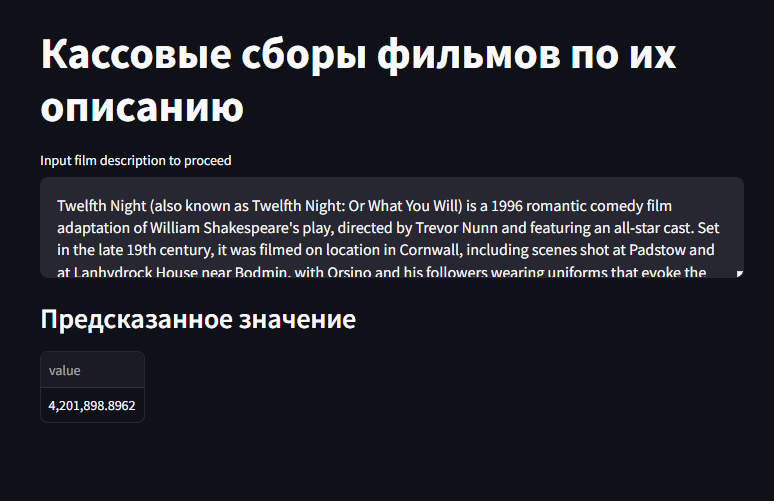